# PID Controller Visualization
## Let's play with PIDs
用摇杆或者角位移传感器作为输入改变参数值，用按钮切换要改变的参数
->最后用的按键和开关解决。

In [9]:
import matplotlib
# for plotting graphs
import matplotlib.pyplot as plt
# for plotting images
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
#from IPython.display import display, HTML
# for working with array-like data structures
import numpy as np

from pynq import PL
from pynq.overlays.base import BaseOverlay

base = BaseOverlay("base.bit")
    
sv = []

# Our timeStep is 0.01 in a timeInterval of 10seconds, giving us 1,000 points to have a set value for
for i in range(0,1000):
    sv.append(0)

# We're going to place a jump for our set value back to 23 degrees at 2.5 seconds (the 249th point in the sv list)
# and have the temperature return back to 0 degrees around 7.5 seconds.
for i in range(249,750):
    sv[i] = 23

## PID Controller Define
实现PID误差控制的功能

In [10]:
def PIDController(pv_, Kp_, Ki_, Kd_):
    # Our pv (present value) and sv (set value) lists
    pv = [pv_]
    
    # We'll add another list for keeping track of the accumulated error for our integral term as we move along
    # in the simulation
    accumulatedError = [0]
    
    # We'll add a variable to keep track of what the previous error was
    previousError = 0
    


    # We'll set the constants for tuning our PID Controller
    
    Kp = Kp_/10
    Ki = Ki_/100
    Kd = Kd_/100


    # We're only going to give our temperature controller a limited time frame, because we're going to plot this data
    # First we determine what the time step of our simulation is going to be.
    timeStep = 0.01
    # Then we determine the time interval we're interested in looking at (how long the sim runs). Assume seconds.
    timeInterval = 10
    # This means we'll have (timeInterval / timeStep) number of measurements to graph
    totalTimeSteps = int(timeInterval/timeStep)

    # Now we define a numpy array for storing our time sequences
    # data = [listOfTime, listOfPV]
    data = np.zeros((totalTimeSteps,2))
    #hdisplay = display(HTML(''), display_id=True) # Initialize display variable
    # Now we implement the proportional-integral controller
    # We'll loop through all the possible time steps in our time interval
    for time in range(0,totalTimeSteps):
        # Calculate the "controller error" at this time step.
        controllerError = sv[time] - pv[time]
        
        # Calculate the "accumulated error" at this time step
        # We can only accumulate error over a time interval
        if time > 0:
            accumulatedError.append(accumulatedError[time-1] + controllerError)
            
        # Calculate the proportional term of our controller
        proportional = Kp*controllerError
        
        #Calculate the inegral term of our controller
        integral = Ki*accumulatedError[time]
        
        #Calculate the derivative term of our controller
        derivative = Kd*(previousError - controllerError)
        # Our current controllerError becomes our previousError
        previousError = controllerError
        
        # Now find the "controller output" 
        controllerOutput = proportional + integral + derivative
        
        # In the simplest case, our controller makes the adjustment immediately. 
        pv.append(pv[time] + controllerOutput)
        data[time,0] = time*timeStep
        data[time, 1] = pv[time+1]

    # print(data)

    # Now we'll plot the data using plt.plot(xValues, yValues)
    # Then call plt.show() to take a look
    plt.plot(data[:,0],data[:,1])
    plt.plot(data[:,0],sv, linestyle="-." )
    plt.legend(['Output','Reference'],loc='best')


    #hdisplay.update(plt.plot(data[:,0],data[:,1]))
    plt.show()

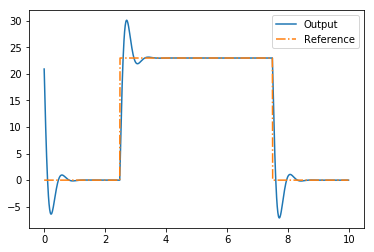

In [11]:
# Call the function as PIDController(pv_, Kp_, Ki_, Kd_)
# 测试是不是好使
#PIDController(23,0.1,0.01,0.01)

PIDController(23,1,1,1)

## PID Visualization PART I
PID控制的可视化，鼠标交互模式

In [12]:
interact(PIDController,pv_ = widgets.FloatSlider(value=23,min=0,max=30.0,step=0.5,continuous_update=False), Kp_= widgets.FloatSlider(value=1,min=0,max=30,step=0.1,continuous_update=False), Ki_= widgets.FloatSlider(value=1,min=0,max=30,step=0.1,continuous_update=False),
    Kd_= widgets.FloatSlider(value=1,min=0,max=30,step=0.1,continuous_update=False))

interactive(children=(FloatSlider(value=23.0, continuous_update=False, description='pv_', max=30.0, step=0.5),…

<function __main__.PIDController>

## PID Visualization PART II
PID控制的可视化，按键、开关交互模式。采用协程的方式实现
P.S.本来想采用角位移传感器和摇杆，但是新版库一直不好使,更新之后旧版库也不好使就没加！！！
臣妾真的做不到啊！！！！！！

创建协程
switch0用来阻塞中断，switch1用来切换参数的增减方向。BTN[0-3]用来控制对应参数的增减

In [13]:
import asyncio
from IPython.display import display, clear_output

Variable = [23,1,1,1]
@asyncio.coroutine
def flash_led(num):
    while True:
        yield from base.buttons[num].wait_for_value_async(1)
        while base.buttons[num].read():
            base.leds[num].toggle()
            if(base.switches[1].read()):
                Variable[num] = Variable[num] - 1
            else:
                Variable[num] = Variable[num] + 1
            if(Variable[num]<=0):
                Variable[num] = 0
            yield from asyncio.sleep(0.2)
        base.leds[num].off()
        #print(Variable[num])
        clear_output(wait=True)
        PIDController(Variable[0],Variable[1],Variable[2],Variable[3])
        print('起始位置:',Variable[0],'P:',Variable[1],'I:',Variable[2],'D:',Variable[3])
tasks = [asyncio.ensure_future(flash_led(i)) for i in range(4)]

每秒打印更新的变量信息

In [ ]:
# import psutil

# @asyncio.coroutine
# def print_variable():
#     while True:
#         yield from asyncio.sleep(1)
#         print(Variable)


# tasks.append(asyncio.ensure_future(print_variable()))

事件阻塞，等待触发

In [ ]:
#随便按一个按键即刻触发
if base.switches[0].read():
    print("Please set switch 0 low before running")
    print(Variable)
else:
    base.switches[0].wait_for_value(1)
    

清理协程：运行完拨一下switch[0]即可

In [ ]:
[t.cancel() for t in tasks]

base.switches[0].wait_for_value(0)